# Analysis of the Proxy-NCA Challenge

In this Notebook, I will discuss my solution to the Proxy-NCA challenge. 

Section 1 of the notebook summarizes the results. The other sections are contain more fine-grained information, linked in the points of section 1. 

Section 2 describes the testing in more detail and shows graphs of the results in 1.1. 

Section 3 contains all of the theoretical new information, I learned during this challenge. 


The notebook is designed to be used together with the table of contents nbextension for jupyter notebooks. This allows the user to easily jump from the summary section to another section to find more specific information.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 1 Summary of Results

This section will be a short overview over the results and the answers to the questions. A more in-depth analysis will be provided in further sections.

### 1.1 Learnings During Training

In the first part of the challenge, I trained and analyzed models based on the [Pytorch implementation](https://github.com/dichotomies/proxy-nca) of [No Fuss Distance Metric Learning using Proxies](https://arxiv.org/abs/1703.07464) on the [UPMC Food-101 dataset](http://visiir.lip6.fr), which contains images and recipes of 101 classes of food.

#### 1.1.1 Theoretical Background
* A summary of the theoretical background of the method can be found in section 3.1.1.2

#### 1.1.2 Pytorch Implementation
* Input parameters:
    * `lr`: learning rate of the proxies
    * `scl_x`: scaling of the normalized tensor containing the embeddings (of each batch)
    * `scl_p`: scaling of the normalized tensor containing the proxies
    * `sz_emb`: dimensionality of the embeddings
    * `seed`: used to seed numpy, pytorch and cuda
* Choosing the right scaling factors for a given dataset is a very important step. Suboptimal scaling factors lead to poor and unstable model performance.
* The model shows inconsistent performance depending on the Pytorch version used (sec.2.4). Pytorch version 1.1.0 results in expected model performance.
* The implementation does not fully seed cudnn. This leads to issues with reproducibility. This slight issue can be fixed easily by adding the lines:

 `torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False`
 
  at the beginning of the seeding process.
* The Pytorch implementation assigns one proxy to each class in the dataset. To use multiple proxies per class or one proxy per multiple classes, `nm_classes` in line 33 of `proxynca.py` has to be changed to `int(n*nm_classes)`. `n` being the fraction proxies/classes.
#### 1.1.3 Proxy-NCA Learning
* The model's performance can be impacted quite significantly by its initial parameters in certain cases (sec 2.1)
* Clustering performance (NMI) is a very good predictor of classification performance (r@k)


#### 1.1.4 Proxy-NCA applied to the Food-101 dataset
* To use the model to train on the Food-101 dataset, I used the pre-defined cub pipeline with minor changes, since this dataset has a very similar folder structure
* The model converges very quickly. Typically achieving the best results in both recall@k and NBI after about 5 training epochs
* Model starts to deteriorate when trained for more epochs (overfitting?)
* The best performing sets of scaling factors are (2.5):
    * `scl_x` = 1 & `scl_p` = 8
    * `scl_x` = 3 & `scl_p` = 3
    * `scl_x` = 8 & `scl_p` = 1
    
    * All of these pairs perform almost identically
    * This behavior is in line with the other datasets
    * It is also interesting, because the paper suggests scaling x relative to p, in which case the scaling factor pairs scl_x = 1 & scl_p = 1 and scl_x = 3 and scl_p 3 would be equivalent. In practice this is not the case 1,1 is the worst performing setting for all datasets, while 3,3 is among the best in all datasets. This might imply unwanted behavior by the PyTorch implementation.
    * model recall is significantly better when training on a larger dataset (in this case the train dataset or the complete dataset) vs. the test set (2.6)
    * clustering performance seems very similar, although this was only tested in a single example


### 1.2 Incorporating Unlabeled Data into Proxy-Learning

When using unlabeled data with Proxy-NCA, the way data points are assigned to proxies has to be changed. This is part of an algorithm, that at each training step:

1. samples a triplet (x, y, Z)
    x (anchor point)
    y (positive)
    Z (all negatives in the batch)
2. formulates the corresponding proxy triplet by substituting the positive and all negatives through their corresponding proxies (x, p(y), p(Z))
3. calculates the loss
4. updates the network parameters (including proxies)

Step 2 is important when including unlabeled data. The model has two modes of assigning data points to proxies. The static and the dynamic mode:

* static mode: used for labeled data. Assigns the data point to the proxy associated with that point's label
* dynamic mode: used for unlabeled data. Assigns the data point to the closest proxy

The modes are discussed in more detail in sec. 3.1.1.2.

#### Native solution
This means that Proxy-NCA learning is designed with unlabeled data in mind. In cases where the entire dataset consists of only unlabeled data, the dynamic assignment mode can be used for all data points.

In a dataset consisting of both labeled and unlabeled data, it should be possible to combine both assignment techniques. This means, during step 2 of the algorithm, the correct assignment technique is chosen on the fly for each point of the triplet.

#### Using the methodology discussed in  arXiv:1803.00676 ([1])

As an alternative to using a combination of the static and dynamic assignment modes, would be to use the methodology discussed in [1] to refine the prototypes.

To use this methodology to update the prototypes, the assignment process in step 2 of the proxy-NCA training algorithm has to be substituted for the unlabeled data points. Instead of using either the static or dynamic assignment modes, each data point could be substituted by a weighted sum over all of the proxies in the following way:
$$P(x_i) =  \frac{\sum_{c \in C}{p_c z_{i,c}}}{\sum_{c\in C}{z_{i,c}}}$$

or in case of method 3, using soft k-means and masking:

$$P(x_i) =  \frac{\sum_{c \in C}{p_c z_{i,c}m_{i,c}}}{\sum_{c\in C}{z_{i,c}m_{i,c}}}$$
where $z_{i,c}$ is the partial assignment function of the chosen assignment method, calculated for point $x_i$. $m_{i,c}$ is the masking function used to exclude unlabeled data points that are too far from any of the proxies. $C$ contains all labeled classes. These functions are found in [1] under 3.1 and summarized in 3.1.1.5. The assignment method is chosen based on whether the unlabeled dataset in the batch contains data points from a distractor class (a class unknown to the model). $z_c$ can be calculated analogously to [1] by substituting the prototypes through the current proxies.

The labeled data points are assigned using the static assignment mode. The proxies are then updated after calculating the loss for each triplet.

I think this is the best way of integrating [1]'s methodology into proxy-NCA learning, because directly updating the proxies analogously to [1] would likely skew the training results too much and cause the model to behave very similar to a prototypical network.

## 2. In-Depth Analysis of model performance

Plotting Function

In [81]:
def plot_df(data, labels = 'all', title = 'your ad here', colors = 'all'):
    if type(data) != list:
        data = [data]
        color_a = np.array(['b','g','r','m','y','c','k','tomato','darkorange','navy','lime','pink','gold','brown','slateblue','goldenrod'])
    else:
        color_a = np.array(['b','g','r','purple','y','c','k',
                             'navy','lime','pink','m','gold','cyan','dimgrey'])
    fig = plt.figure(figsize = (17,13)) 
    fig.suptitle( title, fontsize = 25)
    gs = fig.add_gridspec(3,2)
    gs.update(wspace = 0.2, hspace = 0.2)

    f_ax1 = fig.add_subplot(gs[0,0])
    f_ax2 = fig.add_subplot(gs[0,1])
    f_ax3 = fig.add_subplot(gs[1,0])
    f_ax4 = fig.add_subplot(gs[1,1], sharex = f_ax2) 
    f_ax5 = fig.add_subplot(gs[2,:])

    axs = [f_ax1, f_ax2, f_ax3, f_ax4, f_ax5]
    subtitles = ['Recall@1', 'Recall@2', 'Recall@4', 'Recall@8', 'Normalized Mutual Information']
    ax_titles = ['r@1', 'r@2', 'r@4', 'r@8', 'NMI']
    for ax_ind in range(len(axs)):
#         axs[ax_ind].set_title(subtitles[ax_ind], fontsize = 18, pad = 12)
        if ax_ind > 1:
            axs[ax_ind].set_xlabel('Epochs', fontsize = 15)
        axs[ax_ind].set_ylabel(ax_titles[ax_ind], fontsize = 15)
    color_ind_base = 0
    for results_df1 in data:
        color_ind = color_ind_base
        for i in results_df1['index'].unique():
            df = results_df1[results_df1['index']==i]
            # Label dictionary
            lbls = {}
            lbls['all'] = f'''lr:{df.lr.unique()[0]},scl_x:{df.scl_x.unique()[0]},scl_p:{df.scl_p.unique()[0]},
            sz_emb:{df.sz_emb.unique()[0]}, seed:{df.seed.unique()[0]}'''
            lbls['seed'] = f'seed:{df.seed.unique()[0]}'
            lbls['lr'] = f'lr:{df.lr.unique()[0]}'
            lbls['ed'] = f'ed:{df.edition.unique()[0]}'
            lbls['batch'] = f'batch:{df.batch.unique()[0]}'
            lbls['version'] = f'Torch version:{df["torch version"].unique()[0]}'
            lbls['scl_x'] = f'scl_x:{df.scl_x.unique()[0]}'
            lbls['scl_p'] = f'scl_p:{df.scl_p.unique()[0]}'
            lbls['index'] = f'index:{df["index"].unique()[0]}'
            if type(labels) == str:
                if labels in lbls.keys():
                    lbl = lbls[labels]
                else: lbl = labels
            elif type(labels) == list:
                for lbl_ind in range(len(labels)):
                    if lbl_ind == 0:
                        label = lbls[labels[lbl_ind]]
                    else:
                        label = f'{label}, {lbls[labels[lbl_ind]]}'
                lbl = label
            
            
            for ax_ind_plot in range(len(axs)):
                if colors == 'all':
                    col_line = color_a[color_ind]
                else:
                    col_line = colors[int(color_ind_base/7)]
                axs[ax_ind_plot].plot(df.epoch, df[ax_titles[ax_ind_plot]], label = lbl, c = col_line)
                
            color_ind += 1
        color_ind_base += 7
    plt.setp(f_ax2.get_xticklabels(), visible=False)
    plt.setp(f_ax1.get_xticklabels(), visible=False)
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    f_ax2.legend(by_label.values(), by_label.keys(), fontsize = 13)
    plt.show()


In [83]:
color_l = ['b','g','r','m','y','c','k','tomato','darkorange','navy','lime','pink','gold','brown','slateblue','goldenrod']
food_df = pd.read_csv('food-results.csv')
cub_df = pd.read_csv(f'cub-results.csv')
car_df = pd.read_csv(f'cars-results.csv')

### 2.1 Impact of Starting Meta-Parameters on model performance

In certain cases, the model's performance reacts very strongly to the seed used, even though, all other parameters remain the same:

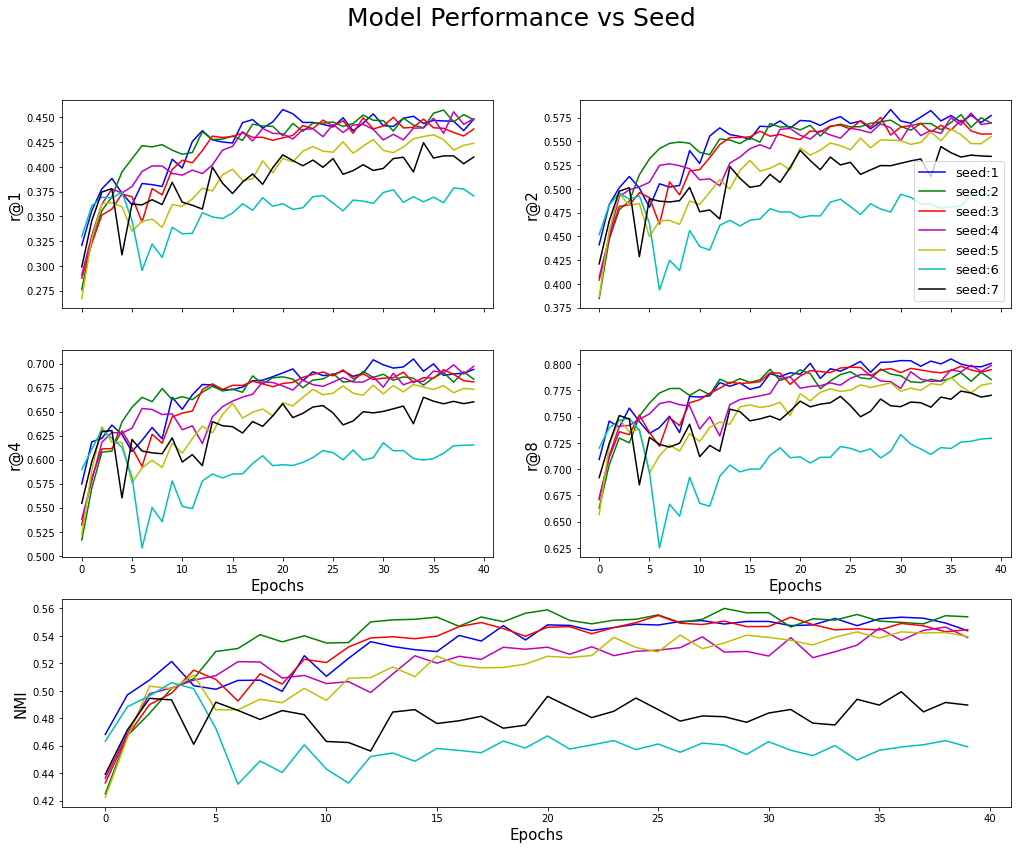

In [4]:
cub_seed_df = cub_df[(cub_df['index'] >= 29) & (cub_df['index'] <= 35)]
plot_df(cub_seed_df, labels = 'seed', title = 'Model Performance vs Seed')

In the models above, all parameters except for the random seed are the same in the example above:
* `lr`: 1
* `scl_x`: 8
* `scl_p`: 8
* `sz_emb`: 64
* `torch version` : 1.1.0
* `batch`: 128

This test was conducted on the cub dataset, since it trains much faster than the food-101 dataset.

My working theory is that using certain scaling values can lead to ill-posed proxy initialization. This could lead to proxy positions not properly converging to correspond to classes.

### 2.2 Impact of Batch Size on Model Performance

In certain cases, the batch size can have a very significant impact on model performance:

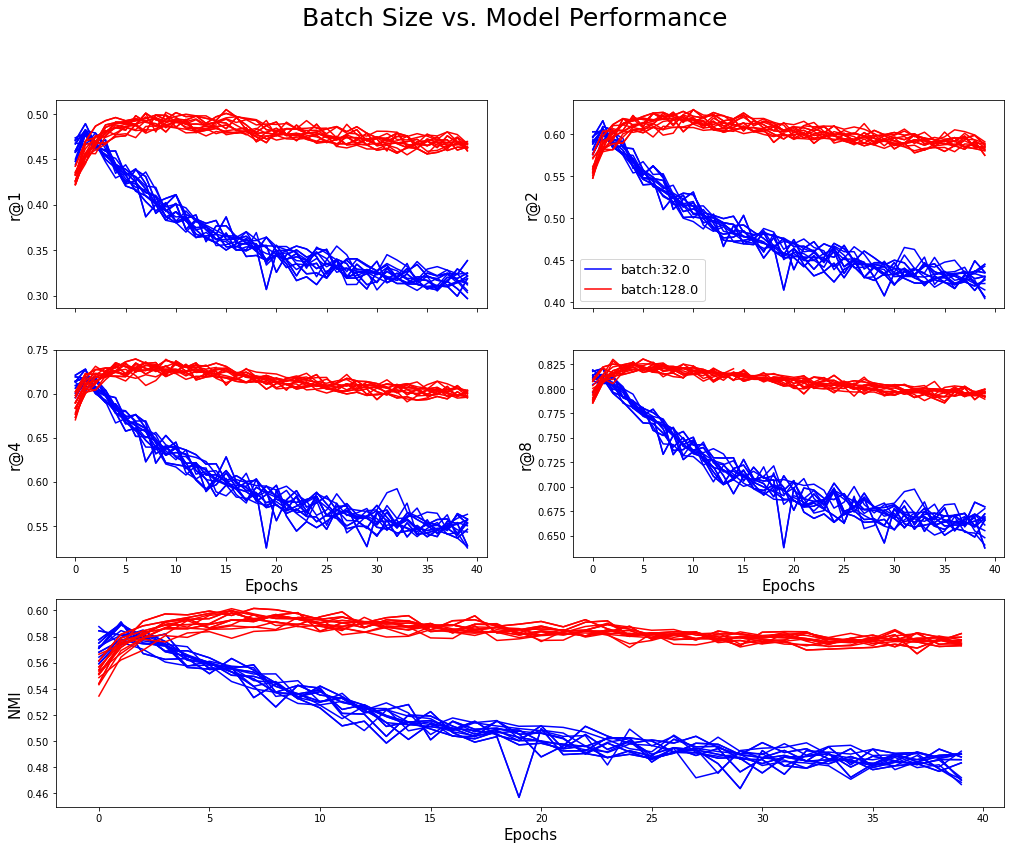

In [5]:
batch_df = cub_df[(cub_df.scl_x ==1) & (cub_df.scl_p == 1) & (cub_df.lr == 1) & 
       (cub_df.batch == 32)]
batch_df1 = cub_df[(cub_df.scl_x ==1) & (cub_df.scl_p == 1) & (cub_df.lr == 1) & 
       (cub_df.batch == 128) & (cub_df['torch version'] == '1.1.0')]
plot_df([batch_df,batch_df1], labels = 'batch', colors = ['b','r'], title = 'Batch Size vs. Model Performance')

This behavior seems to be highly influenced by the scaling parameters. The models above were trained on the cub dataset with scaling parameters:
* `scl_x`: 1
* `scl_p`: 1

The learning rate was also set to 1.

The models using a batch size of 128 converged slower than those of batch size 32, but had a much more stable performance at higher epoch numbers. The models of batch size 32 converged after only a few epochs, but their performance in all metrics quickly dropped off. This could again be caused by ill-posed proxies owing to suboptimal scaling parameters.

This behavior changes significantly with different scaling factors:

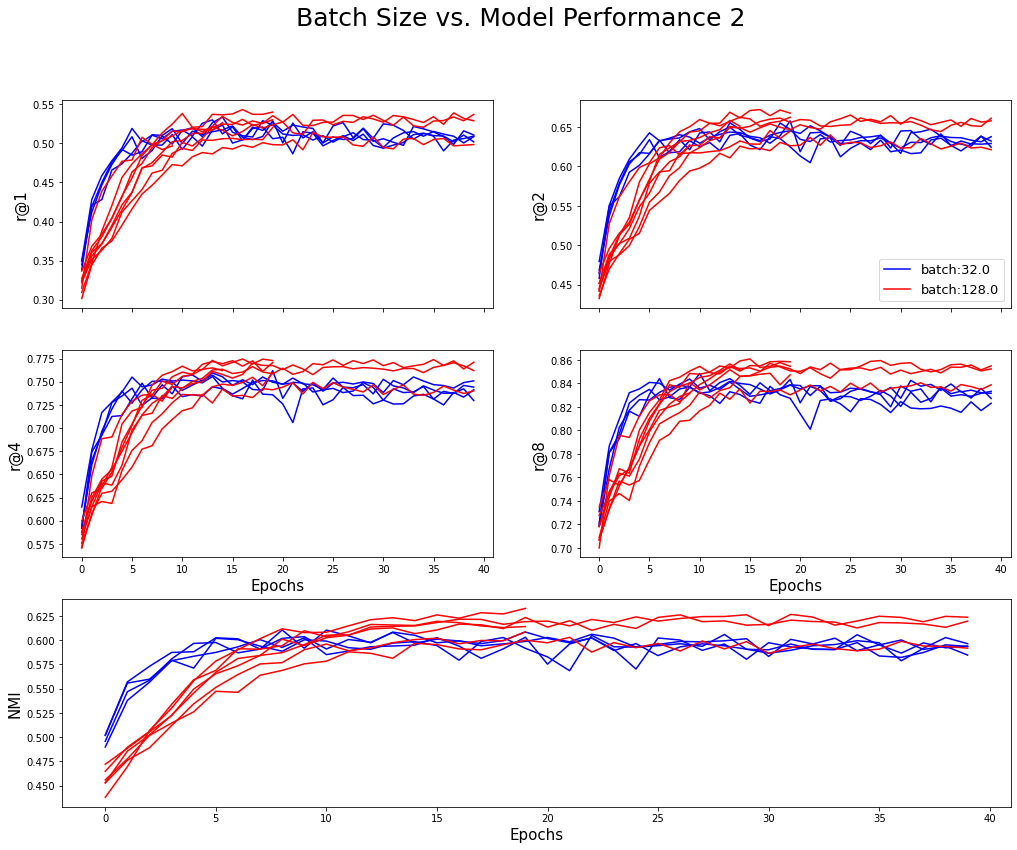

In [6]:
batch_df = cub_df[(cub_df.scl_x ==3) & (cub_df.scl_p == 3) & (cub_df.lr == 1) & 
       (cub_df.batch == 32)]
batch_df1 = cub_df[(cub_df.scl_x ==3) & (cub_df.scl_p == 3) & (cub_df.lr == 1) & 
       (cub_df.batch == 128) & (cub_df['torch version'] == '1.1.0')]
plot_df([batch_df,batch_df1], labels = 'batch', colors = ['b','r'], title = 'Batch Size vs. Model Performance 2')

The models above are trained using the scaling parameters:

* `scl_x` : 3
* `scl_p` : 3

This behavior is very interesting, because the scaling is the same for the proxy tensor and the embeddings tensors, like in the example above, but the models behaved very differently.

### 2.3 Impact of learning rate on performance

The learning rate of the proxies also impacts the resulting performance quite significantly

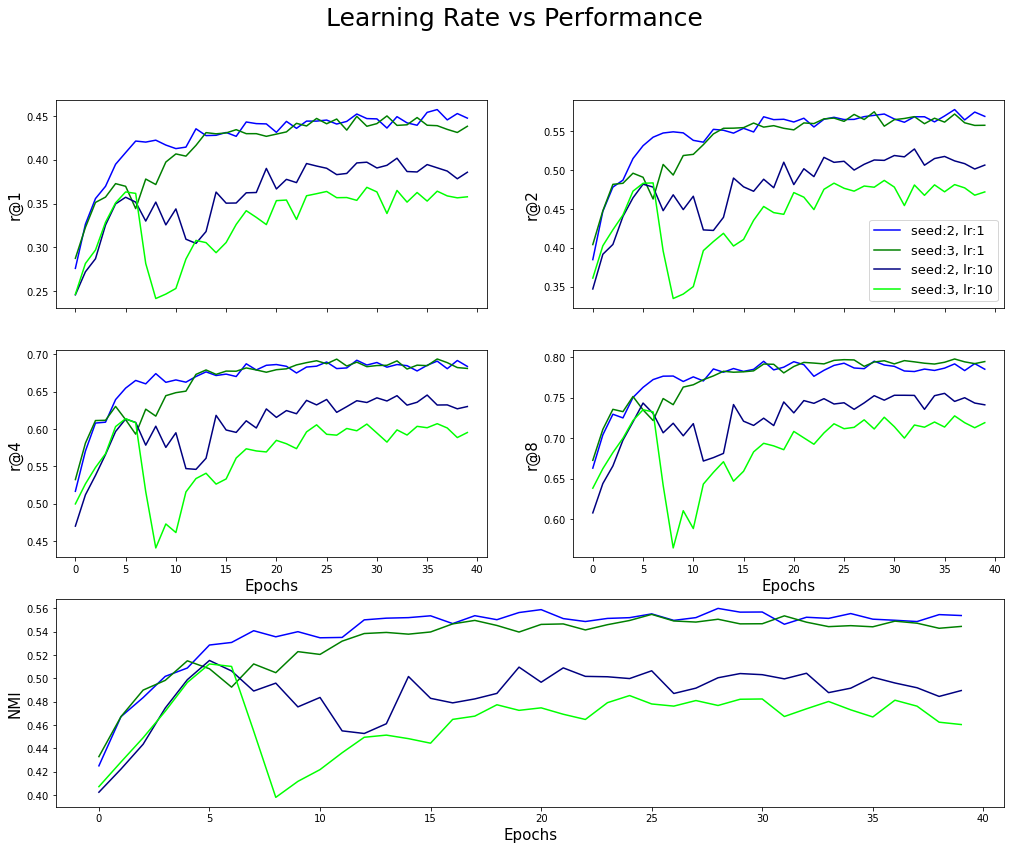

In [7]:
results_df = cub_df
results_df1 = results_df[(results_df.scl_x == 8) & (results_df.scl_p == 8) & (results_df.lr == 1) &
                        (results_df.edition == 0)]
results_df1 = results_df1[(results_df1['seed'] > 1) & (results_df1['seed'] < 4)]
results_df2 = results_df[(results_df.scl_x == 8) & (results_df.scl_p == 8) & (results_df.lr == 10)]
results_df2 = results_df2[(results_df2['seed'] > 1) &(results_df2['seed'] < 4)]
plot_df([results_df1, results_df2], labels = ['seed','lr'], title = 'Learning Rate vs Performance' ) 

In the graphs above, models using a well-performing and a poorly performing seed from sec. 2.1 were used. The blue models are based on seed 2, whereas the green models were based on seed 3.

In the first 4-5 epochs, the models using both learning rates performed very similarly, but diverged after that. The model using a well-performing seed performed worse after this initial period when using a learning rate of 10 instead of 1. The model using the poorly performing seed was able to perform much better with a higher learning rate than with the lower one. This behavior was also seen in other examples.

This behavior might strengthen the idea, that sub-optimal scaling factors lead to a higher likelihood of ill-posed proxies, since the poorly performing model with a higher learning rate might be able to move the ill-posed proxies past local minima in the loss function, finding the absolute minimum. The well-performing model on the other hand might be handicapped by the high learning rate, overshooting the absolute minimum and converging on a local minimum, at higher epoch numbers, when the learning rate decreases.

### 2.4 Inconsistencies with Different Pytorch Editions

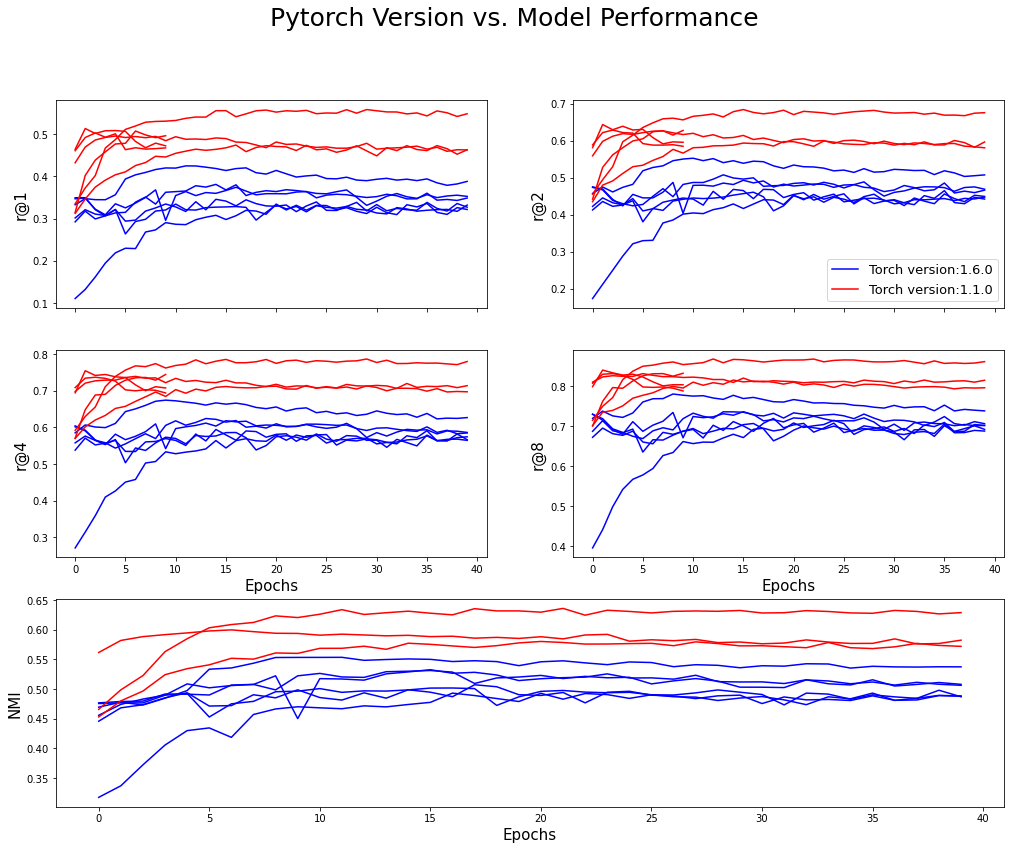

In [8]:
torch_16_df = cub_df[cub_df['torch version'] == '1.6.0']
torch_11_df = pd.DataFrame(columns = torch_16_df.columns)
for ind in torch_16_df['index'].unique():
    df = cub_df[((cub_df.iloc[:,7:-2] == cub_df[(cub_df['index'] == ind)].iloc[1, 7:-2]).sum(axis = 1) == 6)
            & (cub_df['torch version'] == '1.1.0') & 
           (cub_df.batch == 128)]
    torch_11_df = pd.concat([torch_11_df, df])
plot_df([torch_16_df, torch_11_df], colors = ['b','r'], labels = 'version', title = 'Pytorch Version vs. Model Performance')

The models above are trained using all permutations of the scaling parameters on the cub dataset with a batch size of 128. The models trained using the current PyTorch version (1.6.0) performed much worse than the ones trained on version (1.1.0). This became apparent when trying and failing to replicate the results of the author of the PyTorch implementation of proxy-NCA (After an entire day of debugging). The models above are trained on otherwise identical anaconda environments, with only the necessary modules for running `train.ipynb` installed. All other modules are up to date (19.09.2020). A yml file for both environments will be included in the repository.

### 2.5 Scaling Factors

As shown in the previous subsections, the scaling factors impact both the performance and stability of a model in a very significant way. So to find the right scaling factors for the different datasets, a grid search of the scaling parameters was conducted:

In [49]:
for i,j in [1,2],[3,4]:
    print(i,j)

1 2
3 4


In [62]:
# food_32 = food_df[(food_df.batch == 32), labels = 'all']
# [(3,3), (1,8), (8,1)]
def compare_scls(df,scls_lst, labels = 'all', title = None):
    dfs = []
    for scls in scls_lst:
        df_1 = df[(df.scl_x == scls[0]) & (df.scl_p == scls[1])]
        dfs.append(df_1)
    return plot_df(dfs, colors = color_l, labels = labels, title = title)


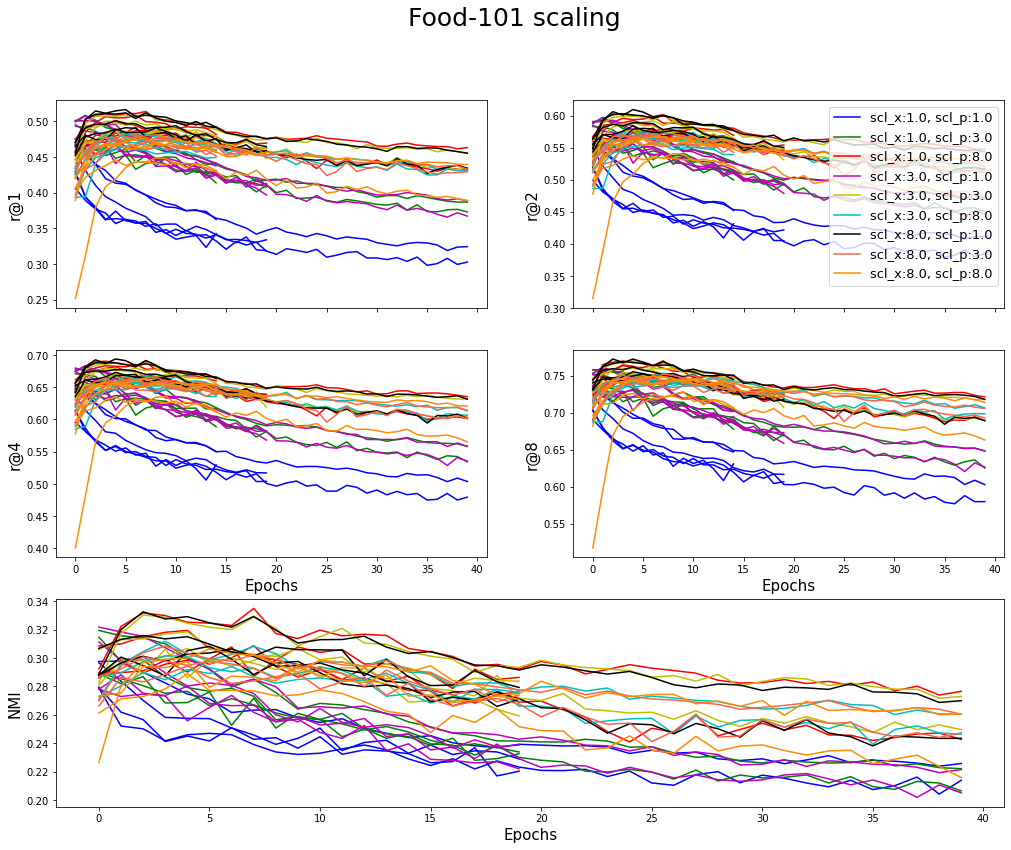

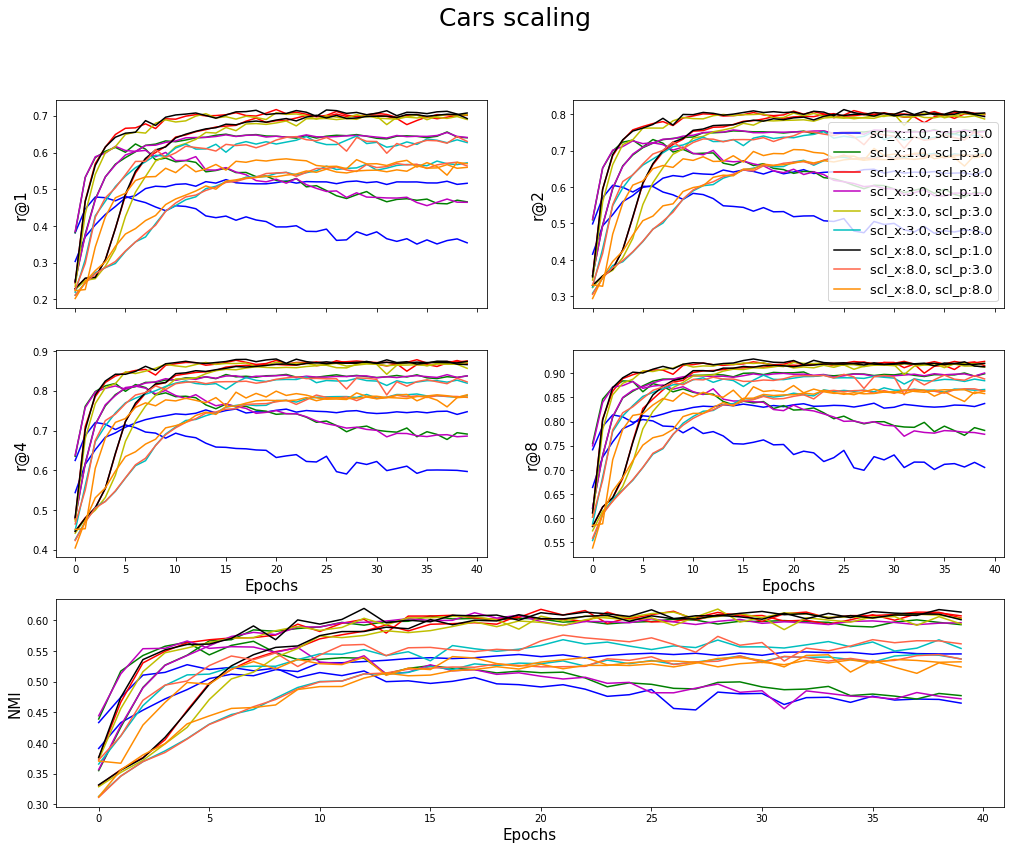

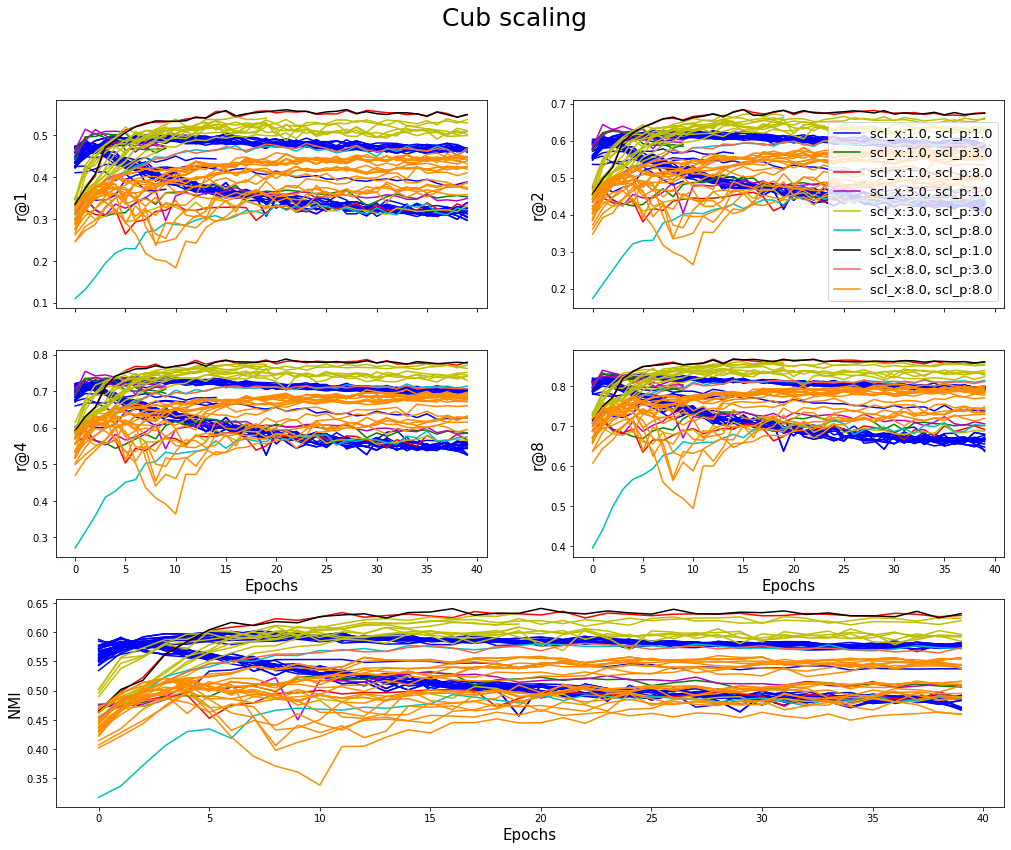

In [67]:
scl_nrs = [1,3,8]
scls_lst = []
for i in scl_nrs:
    for j in scl_nrs:
        scls_lst.append([i,j])
compare_scls(food_df,scls_lst, labels = ['scl_x','scl_p'], title = 'Food-101 scaling')
compare_scls(car_df, scls_lst, labels = ['scl_x','scl_p'], title = 'Cars scaling')
compare_scls(cub_df, scls_lst, labels = ['scl_x','scl_p'], title = 'Cub scaling') 

#### General Results
The models show slightly different behavior relative to the scaling parameters. The split in the cub dataset with scaling factors scl_x = 1 & scl_p = 1 is based on the batch size and was analyzed in 2.2

All datasets perform best on the scaling settings:
    * `scl_x` = 1 & `scl_p` = 8
    * `scl_x` = 3 & `scl_p` = 3
    * `scl_x` = 8 & `scl_p` = 1
    
The performance of these settings often has a split in them, likely do to the performance increase caused by a larger batch size

#### Results of Food-101

In contrast to the other datasets, Food-101 shows a high level of degradation at higher epochs. This could be due to overfitting, but needs to be explored in more detail.

### 2.6 Effects of Training on a Larger Dataset

Due to constraints (mainly RAM), the model was only trained on the training set of Food-101. To see the difference in model performance, additional training was conducted on both the entire dataset and the testing set

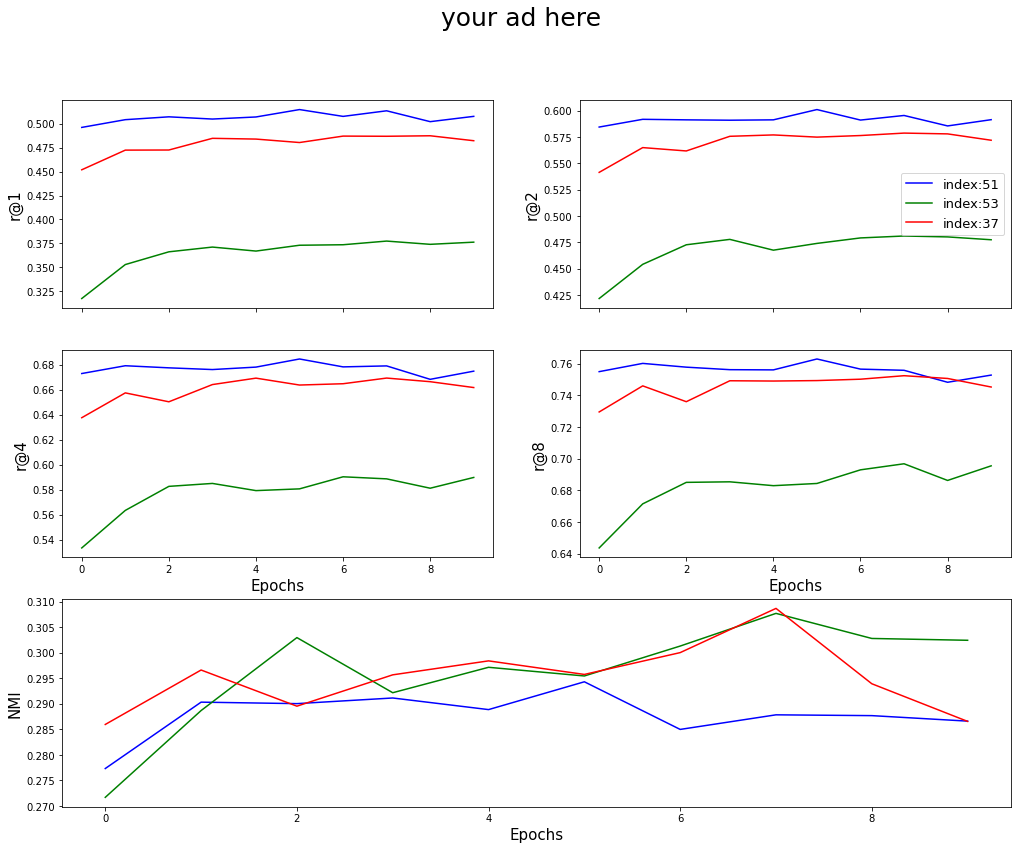

In [97]:
plot_df([food_df[food_df['index'] == 51],food_df[food_df['index'] == 53],
         food_df[(food_df['index'] == 37)& (food_df.epoch < 10 )] ],
        labels = ['index'], colors = color_l)

Above we can see the results of training the model on three different datasets. The model with index:
* 37 was trained on the training set
* 51 was trained on a combination of the training and testing set
* 53 was trained on only the testing set

* The clustering performance of all of the models in the first 10 episodes is very comparable
* The recall performance of the model trained on only the test set is significantly lower than the other two models. This might be caused by the model's lack of choice when picking recalls out of the smaller dataset.

In [93]:
food_df[(food_df.scl_x == 1) & (food_df.scl_p == 8) & (food_df.batch == 32)]['index'].unique()

array([37, 51, 53], dtype=int64)

## 3. Theoretical Background

In this section I will summarize all of the new theoretical background information, I have learned during this challenge

### 3.1 Meta-Learning

* One of the techniques of few-shot and zero-shot learning (haven't found out what the others are)
* "Learning to learn" -> make networks, that quickly adapt to new classes

#### 3.1.1 Metric Learning

* turn data into embeddings: N-dimensional Vectors (typically 64 or 128 dimensions)
* Calculate distance (e.g. Euclidean distance) between embeddings
* Goal: Train model, that translates points of data into embeddings with the characteristics:
    * data points from the same class are close in embedding space
    * data points from different classes are far apart in embedding space
    * classes form clusters in embedding space

##### 3.1.1.1 Prototypical Networks

* used episodic training
* make a prototype embedding $p_c$ for each class $c$ during each episode of training:
* $p_c = \frac{\sum_i{h(x_i)z_{i,c}}}{\sum_i{z_{i,c}}}$, where $x_i$ is a point of data, $h(x)$ the embedding function and ${z_{i,c} = \mathbb{1}[y_i = c]}$
* each prototype is the average of all embeddings in the class in the support set
* model learns embedding function (neural network) to map examples into embedding space where distance corresponds to semantic similarity
* classify data points based on distances to prototypes
* generalization performance is based on test episodes. Prediction of query inputs into the most likely class

##### 3.1.1.2  Proxy-NCA
* Issues to solve:
    * Sampling sets of informative triplets 3.1.1.5 during training is expensive.
    * Convergence of triplet-based techniques is slow.
* Solution:
    * Represent a set of data points through a proxy, a point close to all
      data points in a class or group of classes in embedding space
    * Use the proxies to train the network
    * Proxies are not used for inference
* Advantages:
    * faster (less data points)
    * embeddings of proxies can be stored in ram alone
    * much less computation during training because the number of triplets is significantly reduced by substitution through proxies
    * faster convergence (about 3x according to paper)
    * better scores in zero-shot applications (15% according to paper)
    
* The number of proxies can be a fraction or a multiple of the number of classes
* Distance metric used: Euclidean distance

* Proxy assignment: Two methods:
    * static assignment:
        * Triplets defined by semantic labels
        * Proxies can be associated with semantic labels
          $P = \{p_1..p_L\}$
        * Datapoint assigned to proxy with its label: $p(x) = p_{c(x)}$
        * Triplets do not need to be sampled
        * Only anchor point x needs to be sampled
        * Other proxies $p_i$, where $i {\ne} x$ are then used as the negatives
        * $L_{NCA}(x,p_{c(x)},p(Z);\theta)$
    * dynamic assignment:
        * Used when no semantic labels are available
        * For point x, closest proxy is assigned
        * $p(x) = \underset{p{\in}P }{\mathrm{argmin}}\ d(x,p)$
        * Other proxies are used as negatives
        
* Training Algorithm:
    for i $\in$ T:
        1. Sample triplet (x,y,Z) from D
        2. Formulate proxy triplet (x,p(y),p(Z))
        3. Calculate loss (NCA loss summed over all z $\in$ Z
        4. Update model parameters
        
* Metrics: recall@k and Normalized Mutual Information (described in 3.1.1.3)

##### 3.1.1.3  Metrics:
* recall- @ precision @ k:
    * *predicted*: data point picked by model
    * *relevant*:  data point either has the right semantic ground-truth label or is over threshold picked by user
    1. Use the model to predict from the a query set. order list descending highest confidence
    2. pick the k highest rated items
    * r@k = # of items predicted & relevant @ k / # relevant @ k
    * p@k = # of items predicted & relevant @ k / # predicted @ k
    * range [0,1]: 1 is best
* Normalized Mutual Information (NMI):
    * information shared by variables
    * measure of dependence of variables
    * very computationally expensive (uses scikit-learn clustering on each batch)
    * gives measure of quality of a clustering
    * due to being normalized, can be used to compare clusterings with different numbers of clusters
    * range [0,1]: 1 is best
* When to use which metric
    * NMI provides estimate of the clustering performance
    * recall- & precision @ k estimate the classification performance


##### 3.1.1.4  Episodic Learning

##### 3.1.1.5 Meta-Learning for Semi-Supervised Few-Shot Classification

* Extension to Prototypical Networks (3.1.1.1)
* training set consists of labeled and unlabeled examples (S,R)
* training procedure is analogue to prototypical networks, but instead of using the prototypes $p_i$ in the loss function, refined prototypes $\tilde{p}_i$ are used.
* refined prototypes are calculated by:
    1. calculating the prototypes for a given episode using the labeled data
    2. partially assigning the 
* There are 3 methods for assigning unlabeled data to prototypes:
    1. Soft k-Means
        * This method is used on datasets with no data from distractor classes (not part of the labeled classed in the support set)
        * Analogue to semi-supervised clustering
        * Prototypes are cluster centers
        * each unlabeled data point is partially assigned to all clusters based on their euclidean distance:
        $$\tilde{z}_{j,c} = \frac{exp(-||h(\tilde{x}_j - p_c||^{2}_{2}))}{\sum_{c'}{exp(-||h(\tilde{x}_j - p_{c'} ||_{2}^{2})}}$$
    2. Soft k-Means with a distractor Cluster
        * Additional Cluster for all distractor data at origin
        * distractor points are assigned to the distractor cluster using the partial assignment function:
        $$\tilde{z}_{j,c} = \frac{exp(-\frac{1}{r^{2}_c}||\tilde{x}_j-p_c|| - A(r_c))}{\sum_{c'}{exp(-\frac{1}{r^{2}_{c}}||\tilde{x}_j - p_{c'}||_{2}^{2}- A(r_{c'})})}$$
        $$where$$
        $$A(r) = \frac{1}{2}log(2\pi)+log(r)$$
        * This means points that are too far from other clusters are assigned to the distractor cluster
    3. Soft k-means with masking
        * This method reduces the impact of points based on their distance from the cluster center
        * The masking function m is multiplied with the z function of the unlabeled data (the same used in the Soft k-means method) when calculating the proxies
        
    

##### 3.1.1.6 Triplets:
* Triplets consist of 3 parts:
    * an anchor point (x)
    * a set of similar points (Y)
    * a set of dissimilar points (Z)
* Triplet based loss:
    * goal: learn a distance d where: $d(x,Y) \leq d(x,Z)$
    * Advantage over using 2 points: takes into account relative distance between classes

### 3.1.2 Optimization-based meta-learning:
* Optimize the meta parameters of a model to converge very fast. Examples are MAML, Reptile and LEO.

## 3.2 Recurrent Neural Nets (RNNs)
* Recurrent Neural Nets. Networks, that have a looping component (typically consisting of only a few layers)
* able to combine information from previous data points in following predictions
* struggle with long term memory

### 2.1 Long Short Term Memory (LSTM)
* Able to retain information for a longer amount of time through complicated layers
* gates in the neuron will evaluate which information to forget and which new information to remember. This is very closely controlled and it is intentionally hard for the net to change information in the long term memory.

##### 2.1.2 Inception
* Aim:
    * solve issue of finding right kernel size for the convolutions:
        * Information can be distributed very differently:
           close up photo of a dog: you need a large kernel or the dog will be missed
           dog in the background: small kernel or the dog will be missed
    * reduce depth of network:
        * deep networks lead to overfitting & vanishing gradient
        * too many convolutional layers $\rightarrow$ computationally expensive
* Solution:
    * have filters with different kernel sizes operate on the same level.
      this makes the network "wider" not "deeper"
    * Different architectures for LSTMs (the proxy model uses inception 2)
    * combine different types of convolutions to make the network "wider" instead of "deeper"
        * This means that during a single layer multiple operations can be completed at the same time
        * Reduces issues with neurons "dying" due to the network being too deep